In [10]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation, thresholding, testingPipeline

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math
import sklearn
from collections import defaultdict
from pprint import pprint
import json
import multiprocessing as mp

mp.set_start_method('spawn')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: context has already been set

In [11]:
# data init

# dataset
baseDatasetPath = "../data/datasets"
inclusionThreshold = 0.5
includedSims = 1

# iters to run
iters = [1]

snrs=[3]

#SDs to test
sdMuls = [3]

# gans
batchSize = 64
baseModelPath = "../data/models"
epochs = 5
noiseDim = 200

#results
resultsPath = "../data/results"

demoPath = "../data/demo"

Generating dataset for iteration 1
Processing Simulation: 1, 
33
5
5
Generating non-drowned segment of dataset
Generating dataset with snr 3


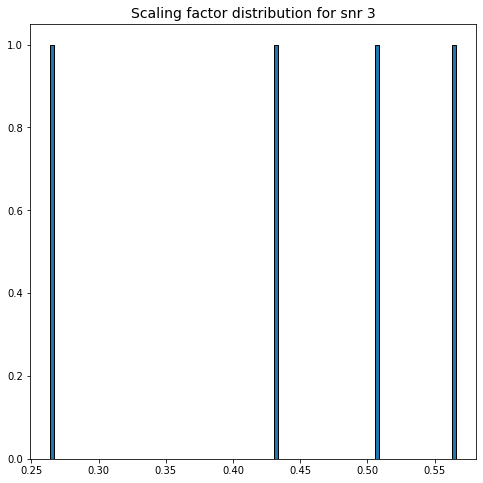

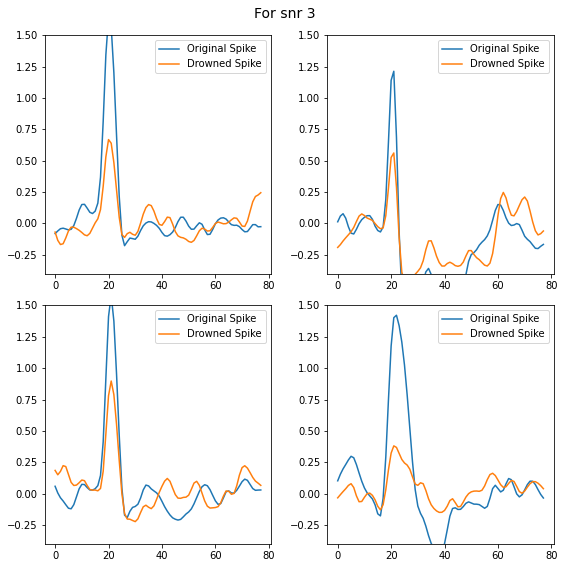

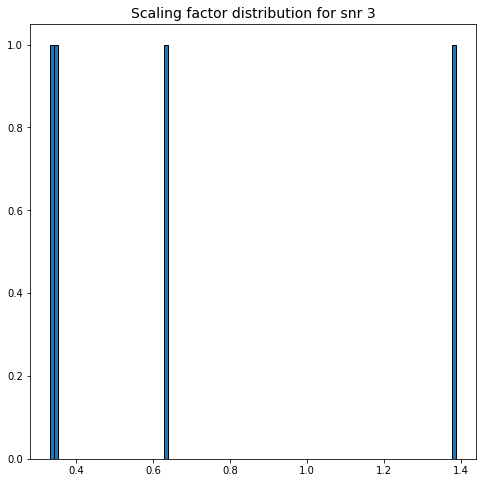

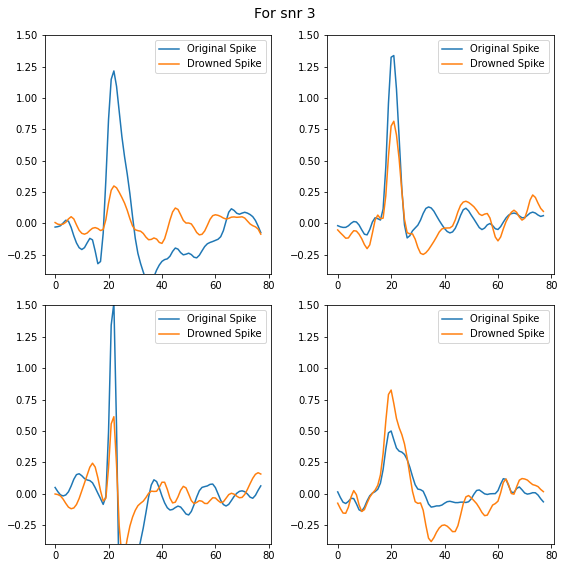

In [12]:
# generate datasets
preprocessing.it_genLoaders( 
    batchSize,
    includedSims,
    doPrint=True,
    snrs=snrs,
    inclusionThreshold=0.5,
    iterations=iters,
    baseDatasetPath=demoPath,
    demo=True
)

In [13]:
# run thresholding pipeline iters times

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

thresholdingRes = defaultdict(thresholdDefault1)

for i in iters:
    print(f"\nIteration {i}\n")
    
    trainSpikesLoader = pickle.load(open(f"{demoPath}/it-{i}-non-drowned-trainSpikesLoader.pickle", "rb"))
    trainBgLoader = pickle.load(open(f"{demoPath}/it-{i}-non-drowned-trainBgLoader.pickle", "rb"))
    valBgLoader = pickle.load(open(f"{demoPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{demoPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    for snr in snrs:
        print(f"\nThresholding dataset with snr {snr}\n")

        valSpikesLoader = pickle.load(open(f"{demoPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{demoPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))

        mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)
        
        for sdMul in sdMuls:
            pred = thresholding.thresholdDatasets(mean, sdMul * sd, testSpikesLoader, testBgLoader)

            labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

            confusionMatrix = testingPipeline.confusionMatrix(labels,pred)

            accuracy, sensitivity, specificity, f1 = testingPipeline.metrics(confusionMatrix)

            thresholdingRes[i][sdMul][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

            print(f"Results for {sdMul} sd")
            print(confusionMatrix)
            print(f"Accuracy: {accuracy}")
            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")

pickle.dump(dict(thresholdingRes), open(f"{demoPath}/thresholdingRes.pickle", "wb"))



Iteration 1


Thresholding dataset with snr 3

Results for 3 sd
[[4 0]
 [2 2]]
Accuracy: 0.75
Sensitivity: 0.5
Specificity: 1.0



Iteration 1

Training GANs
Separating validation noise
torch.Size([4, 80])


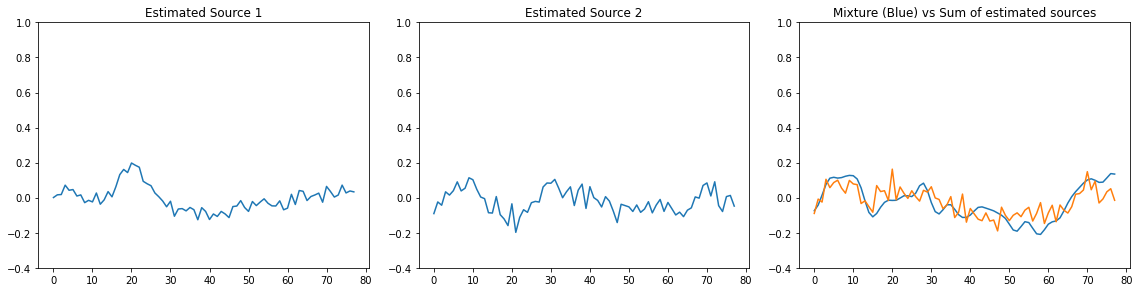

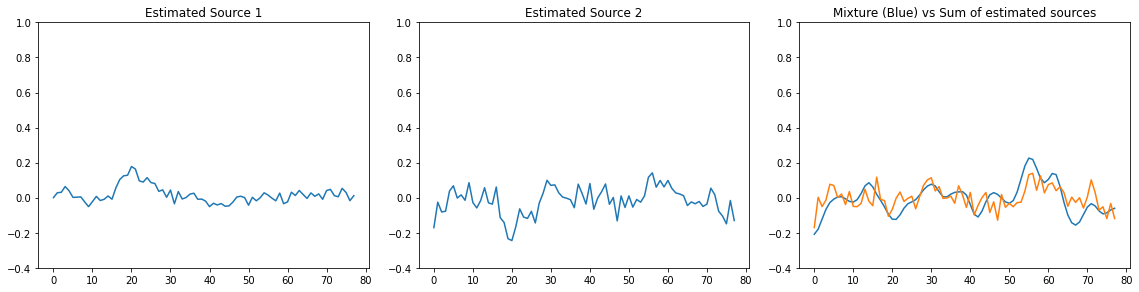

Separating test noise
torch.Size([4, 80])


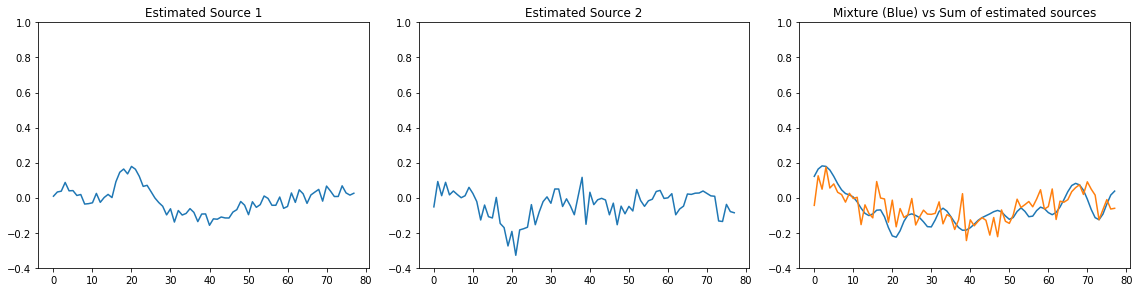

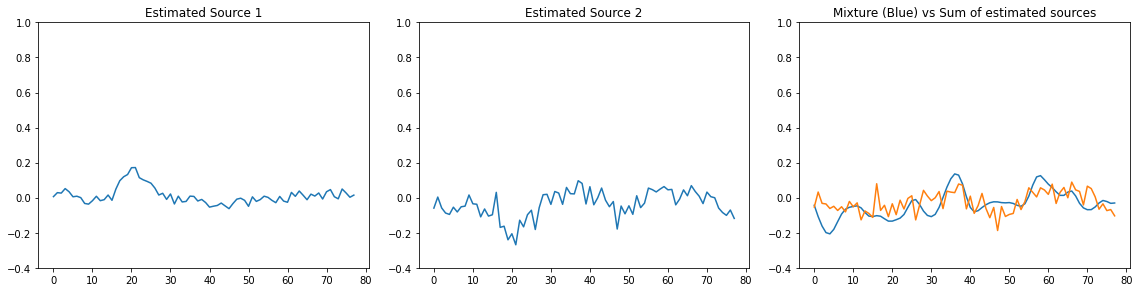


Separating dataset with snr 3

Separating validation spikes
torch.Size([4, 80])


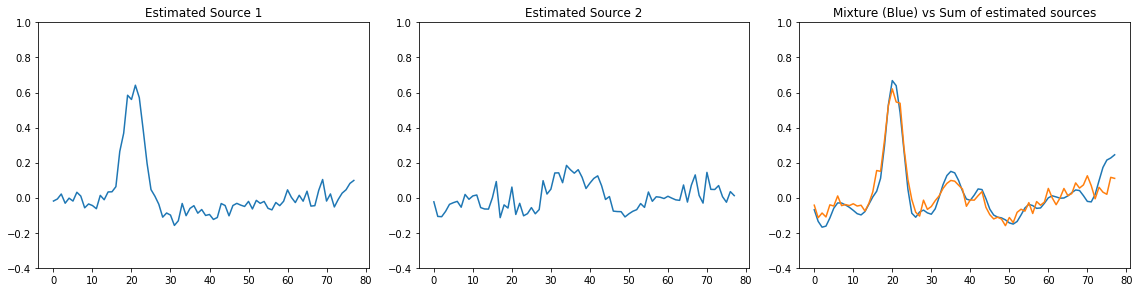

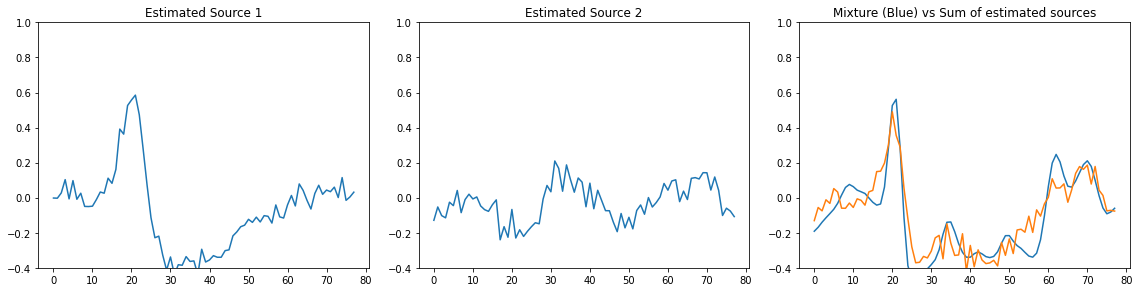

/home/adodon/Documents/Workspaces/Repositories/UTCN/licenta/implementation/sourceseparation_misc/testingPipeline.py:28: RuntimeWarning: invalid value encountered in long_scalars
  precision   = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[0][1])


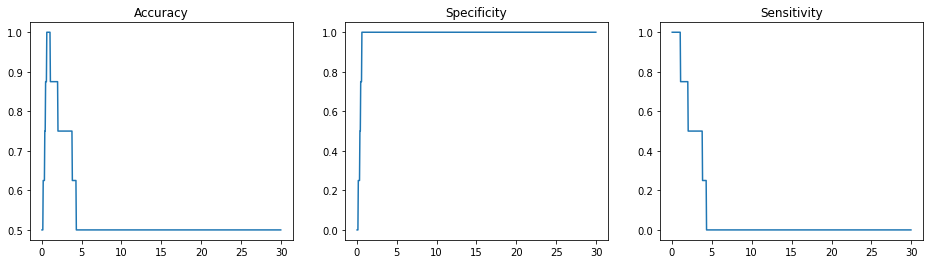

Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 1.0
Specificity: 1.0
Accuracy: 1.0
Separating test spikes
torch.Size([4, 80])


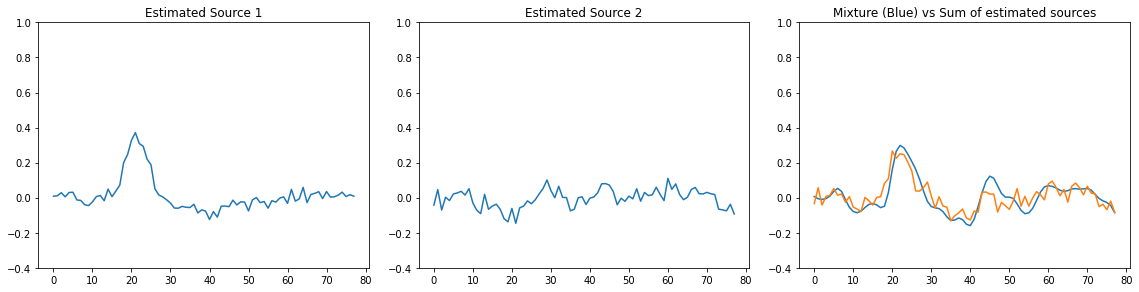

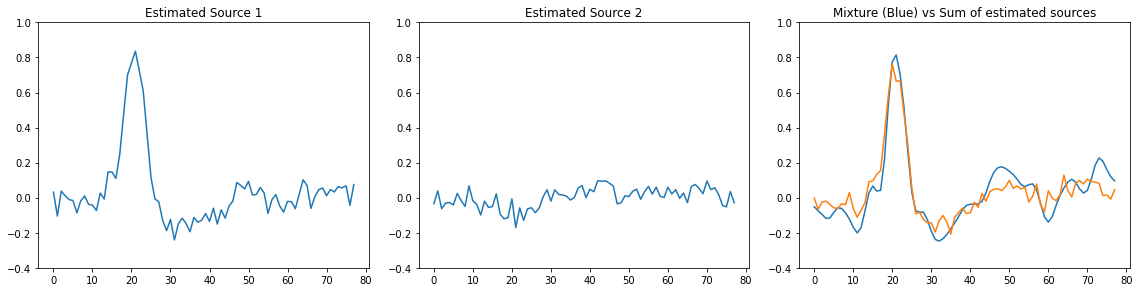

Threshold: 0.65
Sensitivity: 1.0
Specificity: 0.75
Accuracy: 0.875


/home/adodon/Documents/Workspaces/Repositories/UTCN/licenta/implementation/sourceseparation_misc/testingPipeline.py:28: RuntimeWarning: invalid value encountered in long_scalars
  precision   = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[0][1])


In [14]:
# run the separation pipeline iters times

def defaultSep():
    return {}

separationRes = defaultdict(defaultSep)


for i in iters:
    print(f"\nIteration {i}\n")
    
    print("Training GANs")
    #gans.spawnTrainingProcesses(baseDatasetPath, i, baseModelPath, batchSize, noiseDim, epochs)

    genSpike = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticSpike = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-spike.pth"))
    genSpike.to(gans.device)
    criticSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-spike.pth"))
    criticSpike.to(gans.device)
    
    genNoise = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticNoise = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-noise.pth"))
    genNoise.to(gans.device)
    criticNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-noise.pth"))
    criticNoise.to(gans.device)
    
    valBgLoader = pickle.load(open(f"{demoPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{demoPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    # separating noise as it is the same for all snrs
    
    print("Separating validation noise")
    
    (cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg, _) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        discriminators=[criticSpike,criticNoise],
        loader_mix=valBgLoader,
        epochs=3000,
        doPrint=True
    )
    
    print("Separating test noise")
    
    (cleanextractedSpikesTestBg,cleanextractedNoisesTestBg, _) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        discriminators=[criticSpike,criticNoise],
        loader_mix=testBgLoader,
        epochs=3000,
        doPrint=True
    )

    for snr in snrs:
        print(f"\nSeparating dataset with snr {snr}\n")
        
        valSpikesLoader = pickle.load(open(f"{demoPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{demoPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))
        
        print("Separating validation spikes")
        
        (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes, _) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            discriminators=[criticSpike,criticNoise],
            loader_mix=valSpikesLoader,
            epochs=3000,
            doPrint=True
        )
        
        valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
        valExtractedSpikes = torch.from_numpy(valExtractedSpikes)
        vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)
        
        valThreshold, _, _, _, _, _, _ = testingPipeline.interpretSeparation(valExtractedSpikes, criticSpike, vallabel,method="energy",demo=True,doPrint=True)
        
        print("Separating test spikes")
        
        (cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes, _) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            discriminators=[criticSpike,criticNoise],
            loader_mix=testSpikesLoader,
            epochs=3000,
            doPrint=True
        )
        
        testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
        testExtractedSpikes = torch.from_numpy(testExtractedSpikes)
        testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)
        
        _, confusionMatrix, accuracy, sensitivity, specificity, f1, _ = testingPipeline.interpretSeparation(testExtractedSpikes, criticSpike, testlabel,test=True, testThreshold=valThreshold,method="energy",demo=True,doPrint=True)

        separationRes[i][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

pickle.dump(dict(separationRes), open(f"{demoPath}/separationRes.pickle", "wb"))
        
        

defaultdict(<function <lambda> at 0x7fb61a1e61f0>,
            {'accuracy': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fb61a1e6820>,
                                     {3: 0.875}),
             'f1': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fb61a1e6280>,
                               {3: 0.888888888888889}),
             'sensitivity': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fb61a1e6670>,
                                        {3: 1.0}),
             'specificity': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fb61a1e65e0>,
                                        {3: 0.75})})
defaultdict(<function <lambda> at 0x7fb61085aaf0>,
            {'accuracy': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fb61bbd31f0>,
                                     {3: defaultdict(<function <lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x7fb61bbd38b0>,
                                                     {3: 0.75})}),
             'f1': defa

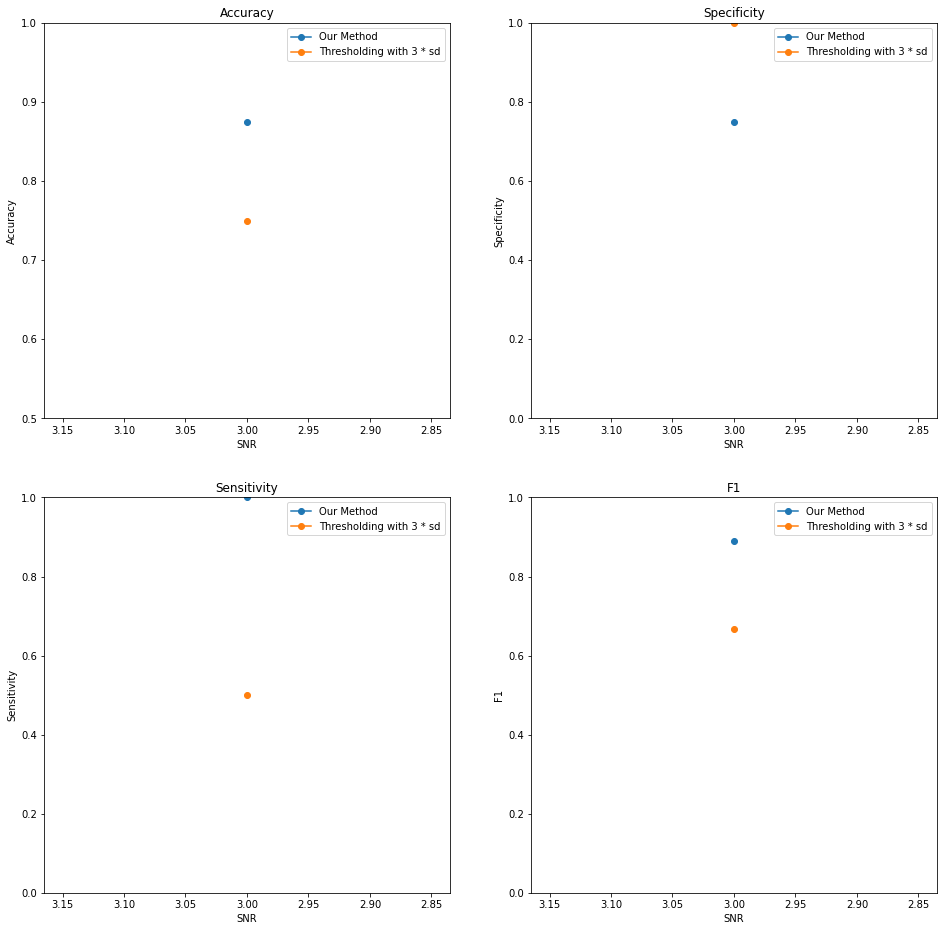

In [15]:
#compute the mean and sds of the metrics
def defaultSep():
    return {}

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

sepRes = pickle.load(open(f"{demoPath}/separationRes.pickle", "rb"))
thRes = pickle.load(open(f"{demoPath}/thresholdingRes.pickle", "rb"))

avgs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
sds = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

thIt = 0

our = defaultdict(lambda: defaultdict(lambda: 0))
ourSds = defaultdict(lambda: defaultdict(lambda: 0))

sepIt = 0

for it in thRes:
    thIt += 1
    for sd in thRes[it]:
        for snr in thRes[it][sd]:
            avgs["accuracy"][sd][snr] += thRes[it][sd][snr][1]
            avgs["sensitivity"][sd][snr] += thRes[it][sd][snr][2]
            avgs["specificity"][sd][snr] += thRes[it][sd][snr][3]
            avgs["f1"][sd][snr] += thRes[it][sd][snr][4]

for metric in avgs:
    for sd in avgs[metric]:
        for snr in avgs[metric][sd]:
            avgs[metric][sd][snr] /= thIt


for it in thRes:
    for sd in thRes[it]:
        for snr in thRes[it][sd]:
            sds["accuracy"][sd][snr] += np.square(thRes[it][sd][snr][1] - avgs["accuracy"][sd][snr])
            sds["sensitivity"][sd][snr] += np.square(thRes[it][sd][snr][2] - avgs["sensitivity"][sd][snr])
            sds["specificity"][sd][snr] += np.square(thRes[it][sd][snr][3] - avgs["specificity"][sd][snr])
            sds["f1"][sd][snr] += np.square(thRes[it][sd][snr][4] - avgs["f1"][sd][snr])

for metric in sds:
    for sd in sds[metric]:
        for snr in sds[metric][sd]:
            sds[metric][sd][snr] = math.sqrt(sds[metric][sd][snr] / thIt) 

for it in sepRes:
    sepIt += 1
    for snr in sepRes[it]:
        our["accuracy"][snr] += sepRes[it][snr][1]
        our["sensitivity"][snr] += sepRes[it][snr][2]
        our["specificity"][snr] += sepRes[it][snr][3]
        our["f1"][snr] += sepRes[it][snr][4]

for metric in our:
    for snr in our[metric]:
        our[metric][snr] /= sepIt


for it in sepRes:
    for sd in sepRes[it]:
        for snr in sepRes[it]:
            ourSds["accuracy"][snr] += np.square(sepRes[it][snr][1] - our["accuracy"][snr])
            ourSds["sensitivity"][snr] += np.square(sepRes[it][snr][2] - our["sensitivity"][snr])
            ourSds["specificity"][snr] += np.square(sepRes[it][snr][3] - our["specificity"][snr])
            ourSds["f1"][snr] += np.square(sepRes[it][snr][4] - our["f1"][snr])

for metric in ourSds:
    for snr in ourSds[metric]:
        ourSds[metric][snr] = math.sqrt(ourSds[metric][snr] / sepIt) 

plt.rcParams['figure.figsize'] = [16, 16]     
fig, axs = plt.subplots(2,2)

axs[0][0].title.set_text("Accuracy")
axs[0][1].title.set_text("Specificity")
axs[1][0].title.set_text("Sensitivity")
axs[1][1].title.set_text("F1")
axs[0][0].set_xlabel("SNR")
axs[0][1].set_xlabel("SNR")
axs[1][0].set_xlabel("SNR")
axs[1][1].set_xlabel("SNR")
axs[0][0].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Specificity")
axs[1][0].set_ylabel("Sensitivity")
axs[1][1].set_ylabel("F1")


axs[0][0].plot(our["accuracy"].keys(), our["accuracy"].values(), label=f"Our Method", marker='o')
axs[0][0].fill_between(np.array(list(our["accuracy"].keys())), np.array(list(our["accuracy"].values())) - np.array(list(ourSds["accuracy"].values())), np.array(list(our["accuracy"].values())) +  np.array(list(ourSds["accuracy"].values())), alpha=0.2)

axs[0][1].plot(our["specificity"].keys(), our["specificity"].values(), label=f"Our Method", marker='o')
axs[0][1].fill_between(np.array(list(our["specificity"].keys())), np.array(list(our["specificity"].values())) -  np.array(list(ourSds["specificity"].values())), np.array(list(our["specificity"].values())) +  np.array(list(ourSds["specificity"].values())), alpha=0.2)

axs[1][0].plot(our["sensitivity"].keys(), our["sensitivity"].values(), label=f"Our Method", marker='o')
axs[1][0].fill_between(np.array(list(our["sensitivity"].keys())), np.array(list(our["sensitivity"].values())) -  np.array(list(ourSds["sensitivity"].values())), np.array(list(our["sensitivity"].values())) +  np.array(list(ourSds["sensitivity"].values())), alpha=0.2)

axs[1][1].plot(our["f1"].keys(), our["f1"].values(), label=f"Our Method", marker='o')
axs[1][1].fill_between(np.array(list(our["f1"].keys())), np.array(list(our["f1"].values())) -  np.array(list(ourSds["f1"].values())), np.array(list(our["f1"].values())) +  np.array(list(ourSds["f1"].values())), alpha=0.2)

for sd in avgs["accuracy"]:
    axs[0][0].plot(avgs["accuracy"][sd].keys(), avgs["accuracy"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[0][0].fill_between(np.array(list(avgs["accuracy"][sd].keys())), np.array(list(avgs["accuracy"][sd].values())) -  np.array(list(sds["accuracy"][sd].values())), np.array(list(avgs["accuracy"][sd].values())) +  np.array(list(sds["accuracy"][sd].values())), alpha=0.2)
for sd in avgs["specificity"]:
    axs[0][1].plot(avgs["specificity"][sd].keys(), avgs["specificity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[0][1].fill_between(np.array(list(avgs["specificity"][sd].keys())), np.array(list(avgs["specificity"][sd].values())) -  np.array(list(sds["specificity"][sd].values())), np.array(list(avgs["specificity"][sd].values())) +  np.array(list(sds["specificity"][sd].values())), alpha=0.2)
for sd in avgs["sensitivity"]:
    axs[1][0].plot(avgs["sensitivity"][sd].keys(), avgs["sensitivity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[1][0].fill_between(np.array(list(avgs["sensitivity"][sd].keys())), np.array(list(avgs["sensitivity"][sd].values())) -  np.array(list(sds["sensitivity"][sd].values())), np.array(list(avgs["sensitivity"][sd].values())) +  np.array(list(sds["sensitivity"][sd].values())), alpha=0.2)
for sd in avgs["f1"]:
    axs[1][1].plot(avgs["f1"][sd].keys(), avgs["f1"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
    axs[1][1].fill_between(np.array(list(avgs["f1"][sd].keys())), np.array(list(avgs["f1"][sd].values())) -  np.array(list(sds["f1"][sd].values())), np.array(list(avgs["f1"][sd].values())) +  np.array(list(sds["f1"][sd].values())), alpha=0.2)

    
pprint(our)
pprint(avgs)
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()

axs[0][0].set_ylim([0.5,1])
axs[0][1].set_ylim([0,1])
axs[1][0].set_ylim([0,1])
axs[1][1].set_ylim([0,1])
axs[0][0].invert_xaxis()
axs[0][1].invert_xaxis()
axs[1][0].invert_xaxis()
axs[1][1].invert_xaxis()

plt.savefig('10-it.png', facecolor='w')
plt.show()
plt.rcParams['figure.figsize'] = [16, 8]     

<AxesSubplot:>

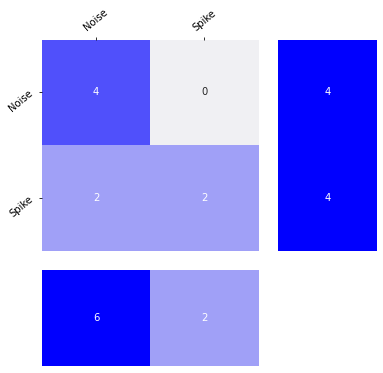

In [16]:
#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = thRes[1][3][3][0]

classes = ["Noise", "Spike"]
fig = plt.figure(figsize=(6,6))

ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (2,0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid((3,3), (0,2), colspan=1, rowspan=2)
sn.color_palette("Paired")
pv = pd.DataFrame(array, index=classes, columns=classes)

c = sn.color_palette("light:b", as_cmap=True)

sn.heatmap(pv, ax=ax1,cmap=c, annot=True, linecolor='b', cbar = False,fmt='g',center=np.mean(pv)[0])
ax1.xaxis.tick_top()
ax1.set_xticklabels(classes,rotation=40)
ax1.set_yticklabels(classes,rotation=40)

sn.heatmap((pd.DataFrame(np.sum(pv,axis=0))).transpose(), ax=ax2,cmap=c,  annot=True, cbar=False, xticklabels=False, yticklabels=False,fmt='g',center=np.mean(pv,axis=0)[0])
sn.heatmap(pd.DataFrame(np.sum(pv,axis=1)), ax=ax3,  annot=True,cmap=c, cbar=False, xticklabels=False, yticklabels=False,fmt='g',center=np.mean(pv,axis=1)[0])


<AxesSubplot:>

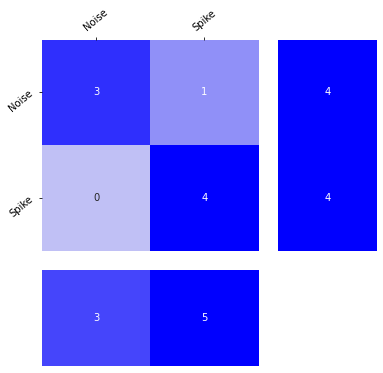

In [17]:
#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = sepRes[1][3][0]

classes = ["Noise", "Spike"]
fig = plt.figure(figsize=(6,6))

ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (2,0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid((3,3), (0,2), colspan=1, rowspan=2)
sn.color_palette("Paired")
pv = pd.DataFrame(array, index=classes, columns=classes)

c = sn.color_palette("light:b", as_cmap=True)

sn.heatmap(pv, ax=ax1,cmap=c, annot=True, linecolor='b', cbar = False,fmt='g',center=np.mean(pv)[0])
ax1.xaxis.tick_top()
ax1.set_xticklabels(classes,rotation=40)
ax1.set_yticklabels(classes,rotation=40)

sn.heatmap((pd.DataFrame(np.sum(pv,axis=0))).transpose(), ax=ax2,cmap=c,  annot=True, cbar=False, xticklabels=False, yticklabels=False,fmt='g',center=np.mean(pv,axis=0)[0])
sn.heatmap(pd.DataFrame(np.sum(pv,axis=1)), ax=ax3,  annot=True,cmap=c, cbar=False, xticklabels=False, yticklabels=False,fmt='g',center=np.mean(pv,axis=1)[0])
